# Ames Modeling

Load the dataset, begin modeling.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from itertools import combinations

In [86]:
#housing_nick = pd.read_csv('data/NH_DF.csv')
#housing_cats = pd.read_csv('data/housing_with_cats.csv')
housing = pd.read_csv('data/housing_numerical.csv')

housing.drop('latitude',axis=1,inplace=True)
housing.drop('longitude',axis=1,inplace=True)
housing.drop('DateSold',axis=1,inplace=True)

#housing.count()
#housing.info()
#housing.describe()

In [87]:
# Fill NaN with 'None' for categorical columns, and fill NaN with 0 for numerical features.
# Loop through each feature and examine
for i, feature in enumerate(housing.columns):
    if housing[feature].dtype=='object':
        housing[feature]=housing[feature].fillna('None')
        #print(i,feature,housing[feature].unique())
        #print(i)
    else:
        h_mean = housing[feature].mean()
        housing[feature] = housing[feature].fillna(h_mean)
        #print(housing[feature].describe())
        #print(i)


# Simple Linear Regression (SLR)

In [88]:
def SLR(X, y):
    #Set up the model
    lm = LinearRegression()
    lm.fit(X, y)
    score=lm.score(X, y)
    return score


# Multiple Linear Regression (MLR)

In [89]:
def MLR(X, y):
    # Split the dataset into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test) # Make predictions on the test set
    r2_value_calculated = r2_score(y_test, y_pred)
    coef = lm.coef_
    return [r2_value_calculated, coef]


# Multiple Linear Regression (MLR) with k-fold CV

In [90]:
def MLR_kfold(X,y,k):
    # Create an instance of KFold with the desired number of folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store RMSE and R-squared values for each fold
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    
    # Iterate over the folds
    i=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 2. Modeling (MLR)
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test) # Make predictions on the test set
        
        # 3. Evaluation Calculate MAE, MSE, and RMSE for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Append the scores to the respective lists
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print(i,"R-squared:", r2)
        i=i+1

    return [rmse_scores, r2_scores]


# Penalized Regression with k-fold CV

In [91]:
# These functions do penalized regression on ridge, lasso, and elastic net
# regression models with k-fold cross validation, and uses GridSearchCV to 
# determine the best alpha

def grid_alpha(X,y,model):
    # Do GridSearchCV to find best alpha
    params = {'alpha': np.linspace(0, 1, 5)}
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', return_train_score=True)
    gX_train, gX_test, gy_train, gy_test = train_test_split(X, y, test_size=0.2, random_state=42)

    gX_train = StandardScaler().fit_transform(gX_train)
    gX_train = pd.DataFrame(gX_train)
    
    grid.fit(gX_train, gy_train)
    best_alpha = grid.best_params_['alpha']
    print("best alpha for ",model,": ",best_alpha)
    return best_alpha
    
def penalized(X,y,k,ratio):
    print("Ridge, Lasso, and Elastic Net with GridSearchCV for alpha")
    print("Features:\n", list(X.columns.values))

    ridge_alpha = grid_alpha(X,y, Ridge())
    lasso_alpha = grid_alpha(X,y, Lasso())
    enet_alpha = grid_alpha(X,y, ElasticNet())
       
    # Create an instance of KFold with the desired number of folds, iterate
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_train_s = pd.DataFrame(X_train_s)

        ############################ Create Models ###########################################     
        ridge_model = Ridge(alpha=ridge_alpha) 
        lasso_model = Lasso(alpha=lasso_alpha)
        elasticnet_model = ElasticNet(alpha=enet_alpha, l1_ratio=ratio) # Ratio mixing parameter controls balance between Ridge and Lasso
    
        # Fit the models on the training data
        ridge_model.fit(X_train_s, y_train)
        lasso_model.fit(X_train_s, y_train)
        elasticnet_model.fit(X_train_s, y_train)
    
        ######################### Make predictions using models #############################
        X_test_s = scaler.transform(X_test)
        X_test_s = pd.DataFrame(X_test_s)
        ridge_predictions = ridge_model.predict(X_test_s)
        lasso_predictions = lasso_model.predict(X_test_s)
        elasticnet_predictions = elasticnet_model.predict(X_test_s)
    
        ############################ Evaluate Models #########################################
        # Calculate R-squared for the models
        ridge_r2 = r2_score(y_test, ridge_predictions)
        lasso_r2 = r2_score(y_test, lasso_predictions)
        elasticnet_r2 = r2_score(y_test, elasticnet_predictions)
    
        print("R-squared for Ridge model:", ridge_r2)
        print("R-squared for Lasso model:", lasso_r2)
        print("R-squared for ElasticNet model:", elasticnet_r2)
    

# Running the models

## Running Simple Linear Regression

In [92]:
# Run SLR for all of the variables (non-nominal)

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)

results = []
# Loop through each feature and examine the score
for i, feature in enumerate(housing[features]):
    X=housing[[features[i]]]
    y=housing['SalePrice']
    score=SLR(X,y)
    results.append([score,feature])

results.sort(reverse=True)
print("R2 for the top 10 Simple Linear Regression models: \nscore, feature\n", results[:10])

R2 for the top 10 Simple Linear Regression models: 
score, feature
 [[1.0, 'SalePrice'], [0.6798715958383224, 'TotalSF'], [0.6298616937506346, 'OverallQual'], [0.5204328184549516, 'GrLivArea'], [0.46774549979837465, 'ExterQual'], [0.43177063751011224, 'KitchenQual'], [0.4283448377541429, 'TotalBsmtSF'], [0.4154510111295472, 'BsmtQual'], [0.4154213603034195, '1stFlrSF'], [0.4120791972028769, 'GarageCars']]


## Running Multiple Linear Regression

In [93]:
best15_features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr'] #top 15 from one of the combinatorics run
X = housing[best15_features]  # Features
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(best15_features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr']
R2 for Multiple Linear Regression model:  0.8649311612533718
Coefficient: [ 6.83147292e+01 -9.36749703e+02  2.82851291e+01  7.10371974e-01
  1.57501567e+04  4.90140681e+03 -3.30065923e+02  2.13539994e+02
  3.76511543e+01  2.11208137e+01  1.13389184e+01 -3.25206899e+00
  2.92076632e+01 -1.76731942e+01 -9.61122618e+03]


In [94]:
# Run MLR with K-fold CV

# MLR with K-fold Cross Validation
features = ['TotalSF','Age']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

print("MLR with k-fold Cross Validation")
print("Features:\n", features)

r = MLR_kfold(X,y,k=5)

#print("Average RMSE:", avg_rmse)
print("Average R-squared:", np.mean(r[1]))
print("Standard deviation of R-squared:", np.std(r[1]))


MLR with k-fold Cross Validation
Features:
 ['TotalSF', 'Age']
0 R-squared: 0.748909898301216
1 R-squared: 0.759749861919766
2 R-squared: 0.7618708846412267
3 R-squared: 0.754905357875141
4 R-squared: 0.7065066069288354
Average R-squared: 0.7463885219332369
Standard deviation of R-squared: 0.020433746298346732


## Running Ridge, Lasso, and Elastic Net

In [95]:
X = housing[best15_features]  # Features
y = housing['SalePrice']  # Target variable

penalized(X,y,k=5,ratio=0.5)

Ridge, Lasso, and Elastic Net with GridSearchCV for alpha
Features:
 ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr']
best alpha for  Ridge() :  1.0
best alpha for  Lasso() :  1.0
best alpha for  ElasticNet() :  0.0
R-squared for Ridge model: 0.8649135069063798
R-squared for Lasso model: 0.864930659918806
R-squared for ElasticNet model: 0.8649311612533729
R-squared for Ridge model: 0.85913503805854
R-squared for Lasso model: 0.8591459351585524
R-squared for ElasticNet model: 0.8591470005336064
R-squared for Ridge model: 0.8643332384953831
R-squared for Lasso model: 0.8643092226447522
R-squared for ElasticNet model: 0.86430421668427
R-squared for Ridge model: 0.8743256069421269
R-squared for Lasso model: 0.8743209107455423
R-squared for ElasticNet model: 0.8743188582203933
R-squared for Ridge model: 0.8598856588949221
R-squared f

## Running categorical var for Vinod

In [96]:
# Run MLR for Vinod's question about categorical variables

#features = ['TotalSF','Age']
#features = ['TotalSF','OverallQual']
features = ['TotalSF','Neighborhood']
X = housing[features]  # Features

# Convert categorical columns to one-hot encoding
X = pd.get_dummies(X, columns=['Neighborhood'], drop_first=True)
y = housing['SalePrice']  # Target variable

r = MLR(X,y)
print(features)
print("R2 for Multiple Linear Regression model: ", r[0])
print("Coefficient:", r[1])

['TotalSF', 'Neighborhood']
R2 for Multiple Linear Regression model:  0.7912020836411895
Coefficient: [5.96965002e+01 1.80183691e+04 2.46125247e+03 6.10022937e+03
 3.09357870e+04 4.39267752e+04 3.20400792e+04 1.13479667e+05
 1.77133054e+04 5.17372451e+04 3.94660442e+04 7.77843590e+03
 1.60107170e+04 5.07121232e+04 6.80960598e+04 7.65711865e+04
 1.69979413e+04 1.02166957e+05 2.11279580e+04 5.09140860e+04
 6.80456047e+04 4.86559995e+04 1.63450113e+05 1.11956439e+05
 6.42902050e+04 2.26043553e+04 4.25261425e+04 3.13489049e+04]


## Results for Vinod's Question Regarding Categorical Variables
3. 

    A) using 2 numerical features.
   
    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'YearBuilt']
    0 R-squared: 0.7416625031183677
    1 R-squared: 0.7217569726901124
    2 R-squared: 0.7396252336514776
    3 R-squared: 0.7284613561793205
    4 R-squared: 0.7450915795474258
    Average R-squared: 0.7353195290373409
    Standard deviation of R-squared: 0.008777731520280862

    ['TotalSF', 'YearBuilt']
    R2 for Multiple Linear Regression model:  0.7416625031183677
    Coefficient: [ 70.20861997 706.57551685]

    B) One using 1 numerical + 1 ordinal (categorial)

    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'OverallQual']
    0 R-squared: 0.792774534309626
    1 R-squared: 0.7624705587335859
    2 R-squared: 0.7877980662360704
    3 R-squared: 0.7687533574218369
    4 R-squared: 0.8070790469236628
    Average R-squared: 0.7837751127249565
    Standard deviation of R-squared: 0.01624674888158771

    ['TotalSF', 'OverallQual']
    R2 for Multiple Linear Regression model:  0.792774534309626
    Coefficient: [   51.60485606 24634.19345553]

    C) One using 1 numerical + 1 nominal (categorical)

    ['TotalSF', 'Neighborhood']
    R2 for Multiple Linear Regression model:  0.7752658566982651
    Coefficient: [ 5.85357913e+01 -1.44534936e+04 -3.07217621e+04 -2.92747827e+04
     -4.59607469e+03  6.31958875e+03  1.76623599e+03 -3.17566089e+04
      4.64969094e+03  2.13902795e+04  1.15656923e+05 -4.11100342e+04
     -1.56651870e+04 -3.97234514e+04 -1.44459331e+04 -2.93749044e+04
     -2.54999577e+04 -1.80343378e+04  6.29015223e+04  6.86566889e+04
     -4.12164036e+04 -4.47433094e+04 -2.49892035e+04 -4.02619715e+03
      2.83089424e+04  6.73020370e+04  2.10537330e+04  1.83914854e+04]

    MLR with k-fold Cross Validation
    Features:
     ['TotalSF', 'Neighborhood']
    0 R-squared: 0.775265856698265
    1 R-squared: 0.7993892323818912
    2 R-squared: 0.7863056427419447
    3 R-squared: 0.7871833976141214
    4 R-squared: 0.7807599813736235
    Average R-squared: 0.7857808221619691
    Standard deviation of R-squared: 0.008039960499637195



##  Multiple Linear Regression using Combinatorics for Feature Selection

In [110]:
# Run MLR for all combinations of features to determine the best combi

#remove categorical non numeric features
housing_num = housing.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)
features.remove('SalePrice')
feature_list = features.copy()
print("Total features:",len(features))

mutual_best = ['TotalSF', 'OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars', 
               'Age','KitchenQual','GarageArea','BsmtFinSF1','1stFlrSF','BsmtQual',
               'LotArea','MasVnrArea','YearRemodAdd','Neighborhood']
features_unkwn = [ elem for elem in features if elem not in mutual_best]
print(len(features_unkwn), "uncertain features")

# Get all R2s of models with one fewer feature, find the best R2, remove lowest feature, repeat
while len(features_unkwn)>1:
    print("Looking at using ",len(features_unkwn)-1, " of these features")
    comb = combinations(features_unkwn, len(features_unkwn)-1)
    results = {}
    #Get all r2 of all combinations of one fewer features
    for c in comb:
        mutual_best_plus = mutual_best.copy()
        mutual_best_plus.extend(c)
        X = housing[mutual_best_plus]  # Features
        y = housing['SalePrice']  # Target variable
        r = MLR(X, y)
        results[r[0]] = mutual_best_plus

    #Sort list of r2s, find best r2, find feature that was not included, drop that feature
    r2s = list(results.keys())
    r2s.sort()
    best_features = results[r2s[0]]
    feature_to_drop = [ elem for elem in feature_list if elem not in best_features]
    print("R2:",r2s[0],"Feature found to drop",feature_to_drop)
    features_unkwn.remove(feature_to_drop[0])
    feature_list.remove(feature_to_drop[0])
print("Last remaining feature",feature_list)    

Total features: 81
66 uncertain features
Looking at using  65  of these features
R2: 0.8844795924879507 Feature found to drop ['BldgType']
Looking at using  64  of these features
R2: 0.8812016615325675 Feature found to drop ['OverallCond']
Looking at using  63  of these features
R2: 0.8772305234981039 Feature found to drop ['Functional']
Looking at using  62  of these features
R2: 0.875224671058177 Feature found to drop ['ScreenPorch']
Looking at using  61  of these features
R2: 0.873164446142345 Feature found to drop ['MSZoning']
Looking at using  60  of these features
R2: 0.8711313542959633 Feature found to drop ['KitchenAbvGr']
Looking at using  59  of these features
R2: 0.8703694224502999 Feature found to drop ['Bath']
Looking at using  58  of these features
R2: 0.8696120501704416 Feature found to drop ['Exterior1st']
Looking at using  57  of these features
R2: 0.8689255795639927 Feature found to drop ['MSSubClass']
Looking at using  56  of these features
R2: 0.8675336145530899 Fea

# LazyPredict Results

In [55]:
from lazypredict.Supervised import LazyRegressor

features = ['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
            'Age', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
            'LowQualFinSF', 'BedroomAbvGr']
X = housing[features]  # Features
y = housing['SalePrice']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)


  5%|██                                          | 2/42 [00:00<00:04,  8.12it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8221848784876566, 'Adjusted R-Squared': 0.8168504248422863, 'RMSE': 31108.16551917727, 'Time taken': 0.13780856132507324}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8838160473707461, 'Adjusted R-Squared': 0.8803305287918686, 'RMSE': 25145.665222492247, 'Time taken': 0.11237525939941406}
{'Model': 'BayesianRidge', 'R-Squared': 0.8648424226588634, 'Adjusted R-Squared': 0.8607876953386293, 'RMSE': 27121.2845291356, 'Time taken': 0.008424043655395508}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7751534888595866, 'Adjusted R-Squared': 0.7684080935253742, 'RMSE': 34981.07343739264, 'Time taken': 0.024670839309692383}
{'Model': 'DummyRegressor', 'R-Squared': -4.298010936176766e-05, 'Adjusted R-Squared': -0.030044269512642607, 'RMSE': 73773.33020994296, 'Time taken': 0.004591703414916992}
{'Model': 'ElasticNet', 'R-Squared': 0.8273110541205199, 'Adjusted R-Squared': 0.8221303857441354, 'RMSE': 30656.482648203473, 'Time taken': 0.00585961341

 17%|███████▎                                    | 7/42 [00:00<00:01, 24.87it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.08644121052193654, 'Adjusted R-Squared': 0.05903444683759462, 'RMSE': 70511.23247140569, 'Time taken': 0.0579988956451416}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7898625743023164, 'Adjusted R-Squared': 0.7835584515313859, 'RMSE': 33817.52030214012, 'Time taken': 0.013492822647094727}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8952214573763881, 'Adjusted R-Squared': 0.8920781010976798, 'RMSE': 23879.555165083184, 'Time taken': 0.4698781967163086}


 24%|██████████▏                                | 10/42 [00:01<00:04,  7.39it/s]

{'Model': 'GammaRegressor', 'R-Squared': 0.8062279375565905, 'Adjusted R-Squared': 0.8004147756832882, 'RMSE': 32473.98879609676, 'Time taken': 0.33382439613342285}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.3295026863105268, 'Adjusted R-Squared': -0.36938776689984265, 'RMSE': 85061.81891919838, 'Time taken': 0.2041771411895752}


 29%|████████████▎                              | 12/42 [00:01<00:05,  5.74it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9176864307700451, 'Adjusted R-Squared': 0.9152170236931464, 'RMSE': 21165.365493490768, 'Time taken': 0.3439507484436035}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9146020290572757, 'Adjusted R-Squared': 0.912040089928994, 'RMSE': 21558.266266883504, 'Time taken': 0.16571617126464844}


 38%|████████████████▍                          | 16/42 [00:02<00:03,  7.66it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.856578411031305, 'Adjusted R-Squared': 0.8522757633622442, 'RMSE': 27938.12914079551, 'Time taken': 0.04753708839416504}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.855972635890937, 'Adjusted R-Squared': 0.8516518149676651, 'RMSE': 27997.068631687885, 'Time taken': 0.028217315673828125}
{'Model': 'KernelRidge', 'R-Squared': -4.939760736564087, 'Adjusted R-Squared': -5.11795355866101, 'RMSE': 179793.72538715234, 'Time taken': 0.11210751533508301}
{'Model': 'Lars', 'R-Squared': 0.8649311612533728, 'Adjusted R-Squared': 0.860879096090974, 'RMSE': 27112.37973858692, 'Time taken': 0.009710311889648438}
{'Model': 'LarsCV', 'R-Squared': 0.8646562498030567, 'Adjusted R-Squared': 0.8605959372971483, 'RMSE': 27139.95721296858, 'Time taken': 0.02459549903869629}
{'Model': 'Lasso', 'R-Squared': 0.864930659918806, 'Adjusted R-Squared': 0.8608785797163702, 'RMSE': 27112.43005500581, 'Time taken': 0.0086822509765625}


 48%|████████████████████▍                      | 20/42 [00:02<00:01, 11.93it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8644181724971434, 'Adjusted R-Squared': 0.8603507176720577, 'RMSE': 27163.817084176084, 'Time taken': 0.0641927719116211}
{'Model': 'LassoLars', 'R-Squared': 0.8649299132111413, 'Adjusted R-Squared': 0.8608778106074756, 'RMSE': 27112.504998110362, 'Time taken': 0.008332014083862305}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8646562498030567, 'Adjusted R-Squared': 0.8605959372971483, 'RMSE': 27139.95721296858, 'Time taken': 0.02404952049255371}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8649311612533728, 'Adjusted R-Squared': 0.860879096090974, 'RMSE': 27112.37973858692, 'Time taken': 0.01541280746459961}
{'Model': 'LinearRegression', 'R-Squared': 0.8651892474643518, 'Adjusted R-Squared': 0.8611449248882823, 'RMSE': 27086.46451934868, 'Time taken': 0.006701231002807617}
{'Model': 'LinearSVR', 'R-Squared': -5.701626983869915, 'Adjusted R-Squared': -5.902675793386013, 'RMSE': 190976.61053131366, 'Time taken': 0.007030010223388672}


 67%|████████████████████████████▋              | 28/42 [00:03<00:01,  8.69it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5.616165801876334, 'Adjusted R-Squared': -5.814650775932624, 'RMSE': 189755.00761236297, 'Time taken': 0.9598965644836426}
{'Model': 'NuSVR', 'R-Squared': -0.010879873690596398, 'Adjusted R-Squared': -0.04120626990131426, 'RMSE': 74171.97283873353, 'Time taken': 0.1244955062866211}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6060347232801243, 'Adjusted R-Squared': 0.594215764978528, 'RMSE': 46304.055338959646, 'Time taken': 0.006014347076416016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8299457522370165, 'Adjusted R-Squared': 0.8248441248041269, 'RMSE': 30421.72232045697, 'Time taken': 0.017815828323364258}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8541489325664607, 'Adjusted R-Squared': 0.8497734005434545, 'RMSE': 28173.76329993604, 'Time taken': 0.038049936294555664}


 74%|███████████████████████████████▋           | 31/42 [00:04<00:02,  5.26it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.9127143685800332, 'Adjusted R-Squared': 0.9100957996374341, 'RMSE': 21795.22890595133, 'Time taken': 1.065063238143921}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': 0.8407023547452894, 'Adjusted R-Squared': 0.8359234253876481, 'RMSE': 29443.85929431575, 'Time taken': 0.06969475746154785}


 81%|██████████████████████████████████▊        | 34/42 [00:05<00:01,  4.09it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8950705334588199, 'Adjusted R-Squared': 0.8919226494625845, 'RMSE': 23896.747135176443, 'Time taken': 1.05271577835083}
{'Model': 'Ridge', 'R-Squared': 0.8649135069063798, 'Adjusted R-Squared': 0.8608609121135712, 'RMSE': 27114.151559994767, 'Time taken': 0.008173704147338867}
{'Model': 'RidgeCV', 'R-Squared': 0.8647442248640107, 'Adjusted R-Squared': 0.860686551609931, 'RMSE': 27131.135130266804, 'Time taken': 0.0076711177825927734}
{'Model': 'SGDRegressor', 'R-Squared': 0.8658374834723963, 'Adjusted R-Squared': 0.8618126079765682, 'RMSE': 27021.26356330245, 'Time taken': 0.011515378952026367}


 90%|██████████████████████████████████████▉    | 38/42 [00:05<00:00,  5.71it/s]

{'Model': 'SVR', 'R-Squared': -0.05935824312909177, 'Adjusted R-Squared': -0.09113899042296447, 'RMSE': 75929.66447285078, 'Time taken': 0.17586445808410645}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8651892474643518, 'Adjusted R-Squared': 0.8611449248882823, 'RMSE': 27086.46451934868, 'Time taken': 0.008521795272827148}


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]

{'Model': 'TweedieRegressor', 'R-Squared': 0.7866930984251914, 'Adjusted R-Squared': 0.7802938913779471, 'RMSE': 34071.59849416967, 'Time taken': 0.6532449722290039}
{'Model': 'XGBRegressor', 'R-Squared': 0.9120290735103294, 'Adjusted R-Squared': 0.9093899457156392, 'RMSE': 21880.62074291825, 'Time taken': 0.08388519287109375}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 15
[LightGBM] [Info] Start training from score 177730.119845
{'Model': 'LGBMRegressor', 'R-Squared': 0.9135665320106376, 'Adjusted R-Squared': 0.9109735279709568, 'RMSE': 21688.575317407227, 'Time taken': 0.08411121368408203}
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoos

# VIF

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame with your features (X)
X = housing[['OverallQual', 'TotalSF', 'GarageCars', 'Fireplaces', 'YearRemodAdd']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"]

0   41.68
1   25.16
2   10.89
3    2.45
4   23.59
Name: VIF, dtype: float64

In [57]:
#High multicollinearity above. If YearRemodAdd is removed, it's improved

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame with your features (X)
X = housing[['OverallQual', 'TotalSF', 'GarageCars', 'Fireplaces']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"]

0   23.99
1   23.99
2   10.82
3    2.31
Name: VIF, dtype: float64

# RandomForestRegressor

In [58]:
X = housing.drop(['SalePrice','DateSold'],axis=1) # Features
y = housing['SalePrice']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numerical_features),
#        ('cat', categorical_transformer, cat_nom_features)])

# Append classifier to preprocessing pipeline.
#pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                           ('classifier', RandomForestRegressor(n_estimators=100, random_state=42))])
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Preprocessing of training data and train model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
print(f'R^2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')


R^2 Score: 0.9099304382867012
RMSE: 22140.07462339106


In [59]:
# Compute the R^2 scores
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Print R^2 score for each fold
for i, score in enumerate(scores, 1):
    print(f"R^2 Score for fold {i}: {score:.4f}")

# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


R^2 Score for fold 1: 0.8919
R^2 Score for fold 2: 0.9188
R^2 Score for fold 3: 0.8961
R^2 Score for fold 4: 0.9074
R^2 Score for fold 5: 0.9134

Average R^2 Score across the 5 folds: 0.9055


In [60]:
# Convert categorical columns to one-hot encoding
X_train = pd.get_dummies(X_train)

# Handle missing data by filling with the mean value of each column
X_train.fillna(X_train.mean(), inplace=True)

# Now, try training the model again
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# To sort features by importance
sorted_idx = importances.argsort()
for idx in sorted_idx:
    print(f"{X_train.columns[idx]}: {importances[idx]}")


Street: 3.10290206693358e-07
Condition2: 3.183780363041528e-06
PoolArea: 6.877201161457286e-06
PoolQC: 7.312975638993055e-06
3SsnPorch: 2.9252217528054584e-05
MiscFeature: 3.004777856017271e-05
Heating: 3.786785257546531e-05
MiscVal: 5.4764544458474466e-05
RoofMatl: 7.580615451247284e-05
Electrical: 0.00012042599783593619
Alley: 0.0001916344974664655
LandSlope: 0.00019220448173472805
LowQualFinSF: 0.00020669352796820597
GarageQual: 0.00026259671963814804
DistanceCategory: 0.0002637215668529297
BsmtFinSF2: 0.0002831394745820714
Fence: 0.00028326963946327134
BsmtCond: 0.00029873798370696667
BsmtFinType2: 0.00031332168224912544
SaleType: 0.0003301664156474549
PavedDrive: 0.00035982610321008587
HouseStyle: 0.00037233286486706074
ExterCond: 0.00039749402664791833
BldgType: 0.00044607638165485746
Foundation: 0.00047834210153657877
LotConfig: 0.0005222372571232471
LandContour: 0.0005334447424462982
GarageCond: 0.000545689845686773
Condition1: 0.0005458371117463052
Functional: 0.00059309752483

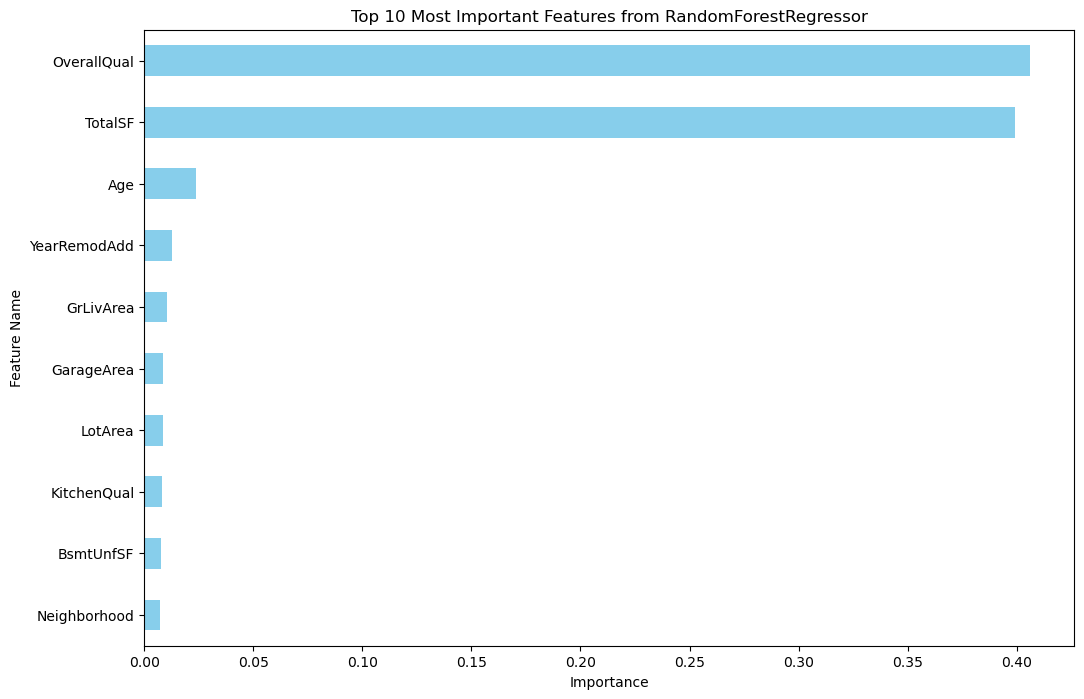

In [61]:
# Map importances to the column names
feature_importances = pd.Series(importances, index=X_train.columns)
top_10 = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # to have the most important feature at the top
plt.show()


# XGBoost Regressor

## Default parameters with k-fold CV

In [62]:
X = housing.drop(['SalePrice','DateSold'],axis=1) # Features
y = housing['SalePrice']

# Initialize the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE and R2 scores for each fold
rmse_scores = []
r2_scores = []

# Perform k-fold cross-validation
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create an XGBoost regressor model
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    # Calculate R2 for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # Display RMSE and R2 for this fold
    print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    fold += 1

# Calculate and print the mean RMSE and R2 across all folds
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R2: {mean_r2:.4f}")


Fold 1: RMSE = 21783.8234, R2 = 0.9128
Fold 2: RMSE = 21257.5422, R2 = 0.9314
Fold 3: RMSE = 21705.7428, R2 = 0.9095
Fold 4: RMSE = 21774.2473, R2 = 0.9133
Fold 5: RMSE = 21688.8447, R2 = 0.9022
Mean RMSE: 21642.0401
Mean R2: 0.9138


## Hyperparameter tuning with GridSearchCV

In [63]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best hyperparameters: {'alpha': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'lambda': 0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


In [64]:
#best_params = {
#    'alpha': 0,
#    'colsample_bytree': 1.0,
#    'gamma': 0.0,
#    'lambda': 1,
#    'max_depth': 3,
#    'min_child_weight': 5,
#    'subsample': 1.0,
#    'objective': 'reg:squarederror'  # This is the default for regression tasks in XGBoost
#}
#grid_search.best_params_
model = xgb.XGBRegressor(**grid_search.best_params_)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    

print("MSE for each fold:", mse_scores)
print("R^2 for each fold:", r2_scores)
print("Average MSE:", sum(mse_scores) / len(mse_scores))
print("Average R^2:", sum(r2_scores) / len(r2_scores))



MSE for each fold: [475231323.57400227, 255351613.35409096, 514992390.22673565, 400508035.73029065, 537202505.0930653]
R^2 for each fold: [0.9227926453211305, 0.9412476200255651, 0.9171853947970594, 0.9276432769673071, 0.8967479286742865]
Average MSE: 436657173.59563696
Average R^2: 0.9211233731570697


## Feature Importance

In [65]:
# Create an XGBoost regressor model (if you haven't already)
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(25))


         Feature  Importance
16   OverallQual        0.43
77       TotalSF        0.22
53    GarageCars        0.05
39    CentralAir        0.04
46   KitchenQual        0.03
28      BsmtQual        0.02
56    GarageCond        0.02
76           Age        0.02
48    Fireplaces        0.01
14      BldgType        0.01
17   OverallCond        0.01
11  Neighborhood        0.01
18  YearRemodAdd        0.01
79          Bath        0.01
78      BsmtBath        0.01
10     LandSlope        0.01
32    BsmtFinSF1        0.01
62   ScreenPorch        0.01
57    PavedDrive        0.00
4        LotArea        0.00
25     ExterQual        0.00
2       MSZoning        0.00
54    GarageArea        0.00
23    MasVnrType        0.00
6          Alley        0.00


# Gradient Boosting Regressor

## First run with no tuning

In [66]:
X = housing.drop(['SalePrice','DateSold'],axis=1) # Features
y = housing['SalePrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])
#
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numerical_features),
#        ('cat', categorical_transformer, cat_nom_features)])

# Append classifier to preprocessing pipeline.
#pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                           ('classifier', GradientBoostingRegressor(random_state=42))])

# Preprocessing of training data and train model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)
   
# Calculate RMSE for this fold
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#print(r2)
# Compute the R^2 scores
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")


Average R^2 Score across the 5 folds: 0.9241


In [67]:
param_grid = {
    'max_depth': [3, 5, 6, 7],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'subsample': [0.7, 0.8, 0.9],
    'alpha': [0, 0.5, 0.9]
}
#['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 
# 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 
# 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 
# 'tol', 'validation_fraction', 'verbose', 'warm_start']

model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
print(f"Best hyperparameters: {grid_search.best_params_}")



Fitting 3 folds for each of 23328 candidates, totalling 69984 fits


KeyboardInterrupt: 

In [68]:
#X.to_csv('data/CharlotteX.csv', index=False)
#y.to_csv('data/y.csv', index=False)

In [69]:
#My best hyperparameters: {'alpha': 0.5, 'max_depth': 5, 'min_weight_fraction_leaf': 0, 'subsample': 0.8}
#0.9219231402135216
#Best hyperparameters: {'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 
#'min_samples_split': 10, 'min_weight_fraction_leaf': 0, 'n_estimators': 600, 'subsample': 0.7}
#0.9279361418087255
new_param = {
    'max_depth': 3,
    'min_weight_fraction_leaf': 0,
    'n_estimators': 4000,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'alpha': 0.5
}

nick_param = {
    'max_depth': 3,
    'n_estimators': 6000,
    'min_samples_split': 5,
    'learning_rate': 0.008,
    'subsample': 0.3
}
#Nicks 1st: n_estimators=10100, max_depth=4, learning_rate=0.01,min_samples_leaf=1, subsample=0.5, random_state=42
#Nicks best: learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model = GradientBoostingRegressor(**grid_search.best_params_)
model = GradientBoostingRegressor(**nick_param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(r2)
# Compute the R^2 scores
scores = cross_val_score(GradientBoostingRegressor(**nick_param, random_state=42), X_train, y_train, cv=5, scoring='r2')
# Print average R^2 score
print(f"\nAverage R^2 Score across the 5 folds: {scores.mean():.4f}")

0.9471942074680881

Average R^2 Score across the 5 folds: 0.9400


In [70]:
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(25))

          Feature  Importance
77        TotalSF        0.36
16    OverallQual        0.26
76            Age        0.03
0       GrLivArea        0.02
28       BsmtQual        0.02
32     BsmtFinSF1        0.02
46    KitchenQual        0.02
4         LotArea        0.02
18   YearRemodAdd        0.02
24     MasVnrArea        0.02
54     GarageArea        0.02
53     GarageCars        0.01
11   Neighborhood        0.01
36    TotalBsmtSF        0.01
35      BsmtUnfSF        0.01
71  SaleCondition        0.01
17    OverallCond        0.01
48     Fireplaces        0.01
41       1stFlrSF        0.01
25      ExterQual        0.01
3     LotFrontage        0.01
51    GarageYrBlt        0.01
42       2ndFlrSF        0.01
62    ScreenPorch        0.01
73  DistanceToISU        0.00
